In [1]:
import sys
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os

src_path = os.path.abspath(os.path.join('..'))
if src_path not in sys.path:
    sys.path.append(src_path)

from src.utils.constants import *

In [2]:
ground_truth = pd.read_parquet(GROUND_TRUTH_PATH)
gt_to_merge = ground_truth.copy()
ground_truth = ground_truth[['origin_time', 'label']]

In [3]:
imported_data = {}

for exchange in EXCHANGES:
  
    imported_data[(CANDLES, exchange)] = pd.read_parquet(os.path.join(INTERIM_DATA_PATH, f'{CANDLES}_{exchange}_merged.parquet'))
    imported_data[(ORDERBOOKS, exchange)] = pd.read_parquet(os.path.join(INTERIM_DATA_PATH, f'{ORDERBOOKS}_{exchange}_merged.parquet'))

In [4]:
for(exchange, data_type), df in imported_data.items():
    print(f'{exchange} {data_type}: {df.shape}')

candles BINANCE: (524101, 26)
orderbooks BINANCE: (478531, 82)
candles HUOBI: (405541, 26)
orderbooks HUOBI: (393119, 82)
candles OKX: (405553, 26)
orderbooks OKX: (393119, 82)


In [ ]:
merged_df = {}
cols_to_drop = ['origin_time', 'label']

for (data_type, exchange), df in imported_data.items():     
    merged_df[(data_type, exchange)] = {}
    merged_df[(data_type, exchange)]['full'] = pd.merge(ground_truth[cols_to_drop], df, on='origin_time', how='inner')
    merged_df[(data_type, exchange)]['X'] = merged_df[(data_type, exchange)]['full'].drop(cols_to_drop, axis=1)
    merged_df[(data_type, exchange)]['y'] = merged_df[(data_type, exchange)]['full']['label']

In [5]:
data = {}

for (data_type, exchange), df in merged_df.items():
    data[(data_type, exchange)] = {}
    data[(data_type, exchange)]['X_train'], data[(data_type, exchange)]['X_test'], data[(data_type, exchange)]['y_train'], data[(data_type, exchange)]['y_test'] = train_test_split(df['X'], df['y'], test_size=TEST_SIZE, random_state=RANDOM_STATE)

Best parameters for BINANCE candles: {'max_depth': 7, 'min_samples_leaf': 50, 'min_samples_split': 10}
BINANCE candles Accuracy: 0.70
BINANCE candles Classification Report:


,precision,recall,f1-score,support
positive,0.373782,0.094381,0.150707,24380.000000
neutral,0.722824,0.970901,0.828694,108250.000000
negative,0.396616,0.091460,0.148642,24601.000000
accuracy,0.697388,0.697388,0.697388,0.697388
macro avg,0.497740,0.385580,0.376015,157231.000000
weighted avg,0.617662,0.697388,0.617163,157231.000000


BINANCE candles Confusion Matrix:


,pred:positive,pred:neutral,pred:negative
true:positive,2301,20112,1967
true:neutral,1694,105100,1456
true:negative,2161,20190,2250


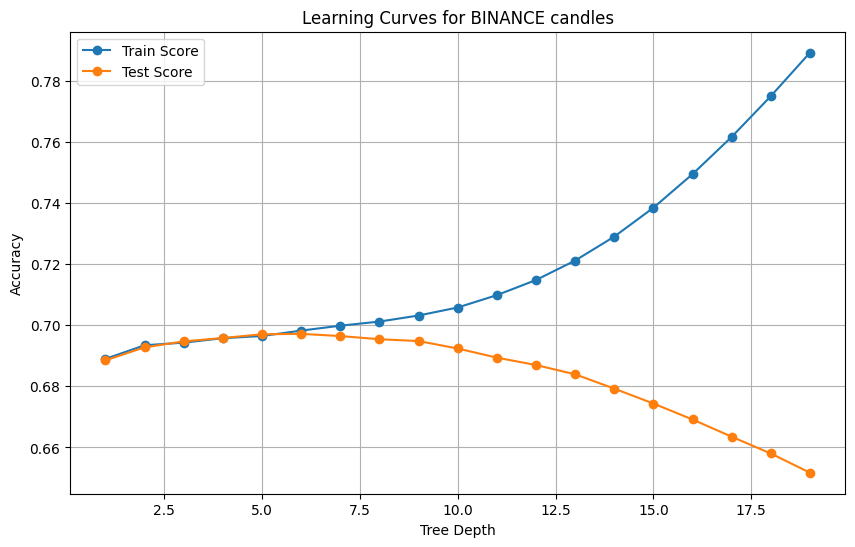

Best parameters for BINANCE orderbooks: {'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 10}


d:\Repository\big_data_bitcoin_forecasting\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Repository\big_data_bitcoin_forecasting\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Repository\big_data_bitcoin_forecasting\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

BINANCE orderbooks Accuracy: 0.69
BINANCE orderbooks Classification Report:


,precision,recall,f1-score,support
positive,0.000000,0.000000,0.000000,21942.000000
neutral,0.693976,0.999870,0.819302,99620.000000
negative,0.310345,0.000409,0.000817,21998.000000
accuracy,0.693898,0.693898,0.693898,0.693898
macro avg,0.334773,0.333426,0.273373,143560.000000
weighted avg,0.529122,0.693898,0.568660,143560.000000


BINANCE orderbooks Confusion Matrix:


,pred:positive,pred:neutral,pred:negative
true:positive,0,21935,7
true:neutral,0,99607,13
true:negative,0,21989,9


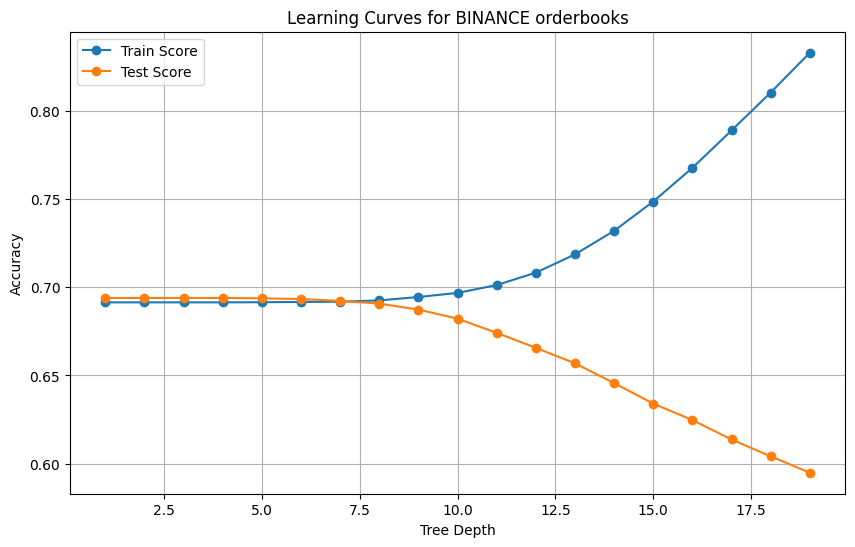

Best parameters for HUOBI candles: {'max_depth': 5, 'min_samples_leaf': 20, 'min_samples_split': 100}
HUOBI candles Accuracy: 0.71
HUOBI candles Classification Report:


,precision,recall,f1-score,support
positive,0.415086,0.050235,0.089624,18294.000000
neutral,0.715783,0.988061,0.830167,84931.000000
negative,0.434645,0.052121,0.093080,18438.000000
accuracy,0.705202,0.705202,0.705202,0.705202
macro avg,0.521838,0.363472,0.337623,121663.000000
weighted avg,0.627962,0.705202,0.607109,121663.000000


HUOBI candles Confusion Matrix:


,pred:positive,pred:neutral,pred:negative
true:positive,919,16602,773
true:neutral,537,83917,477
true:negative,758,16719,961


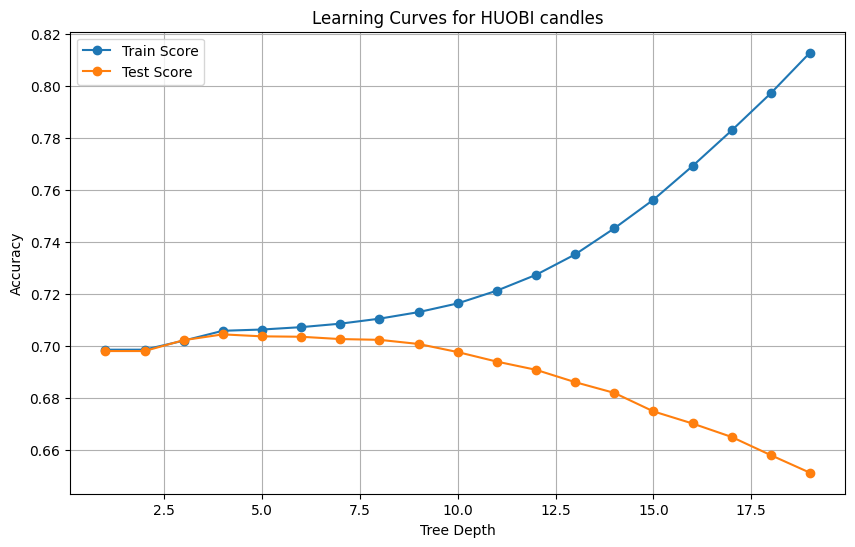

Best parameters for HUOBI orderbooks: {'max_depth': 1, 'min_samples_leaf': 10, 'min_samples_split': 10}


d:\Repository\big_data_bitcoin_forecasting\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Repository\big_data_bitcoin_forecasting\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Repository\big_data_bitcoin_forecasting\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

HUOBI orderbooks Accuracy: 0.69
HUOBI orderbooks Classification Report:


,precision,recall,f1-score,support
positive,0.000000,0.000000,0.000000,18133.00000
neutral,0.690290,1.000000,0.816771,81410.00000
negative,0.000000,0.000000,0.000000,18393.00000
accuracy,0.690290,0.690290,0.690290,0.69029
macro avg,0.230097,0.333333,0.272257,117936.00000
weighted avg,0.476500,0.690290,0.563808,117936.00000


HUOBI orderbooks Confusion Matrix:


,pred:positive,pred:neutral,pred:negative
true:positive,0,18133,0
true:neutral,0,81410,0
true:negative,0,18393,0


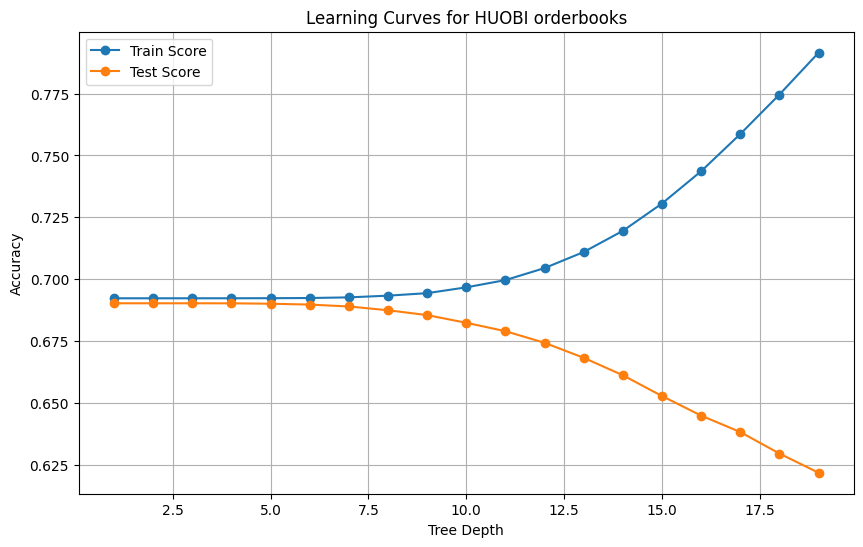

Best parameters for OKX candles: {'max_depth': 7, 'min_samples_leaf': 30, 'min_samples_split': 100}
OKX candles Accuracy: 0.71
OKX candles Classification Report:


,precision,recall,f1-score,support
positive,0.366333,0.099907,0.156997,18297.000000
neutral,0.727797,0.975803,0.833748,85012.000000
negative,0.427829,0.062810,0.109538,18357.000000
accuracy,0.706327,0.706327,0.706327,0.706327
macro avg,0.507320,0.379507,0.366761,121666.000000
weighted avg,0.628178,0.706327,0.622704,121666.000000


OKX candles Confusion Matrix:


,pred:positive,pred:neutral,pred:negative
true:positive,1828,15528,941
true:neutral,1456,82955,601
true:negative,1706,15498,1153


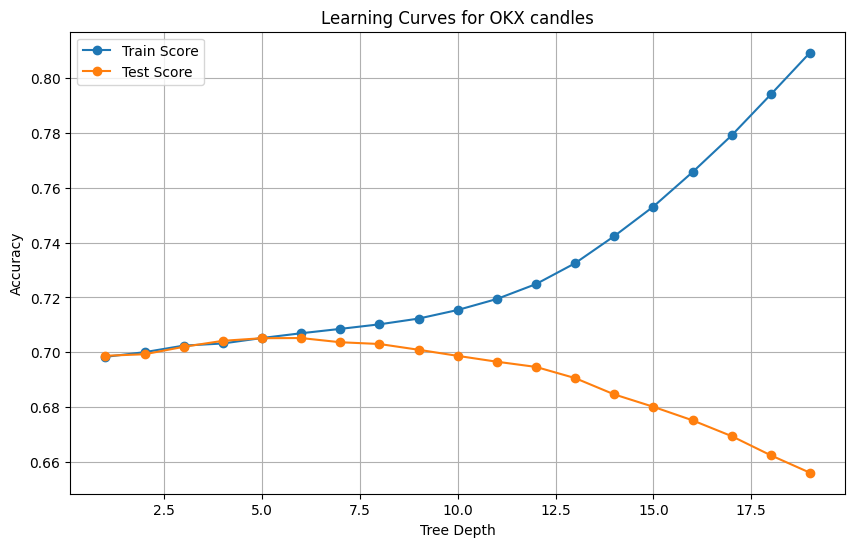

Best parameters for OKX orderbooks: {'max_depth': 1, 'min_samples_leaf': 10, 'min_samples_split': 10}


d:\Repository\big_data_bitcoin_forecasting\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Repository\big_data_bitcoin_forecasting\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Repository\big_data_bitcoin_forecasting\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

OKX orderbooks Accuracy: 0.69
OKX orderbooks Classification Report:


,precision,recall,f1-score,support
positive,0.000000,0.000000,0.000000,18133.00000
neutral,0.690290,1.000000,0.816771,81410.00000
negative,0.000000,0.000000,0.000000,18393.00000
accuracy,0.690290,0.690290,0.690290,0.69029
macro avg,0.230097,0.333333,0.272257,117936.00000
weighted avg,0.476500,0.690290,0.563808,117936.00000


OKX orderbooks Confusion Matrix:


,pred:positive,pred:neutral,pred:negative
true:positive,0,18133,0
true:neutral,0,81410,0
true:negative,0,18393,0


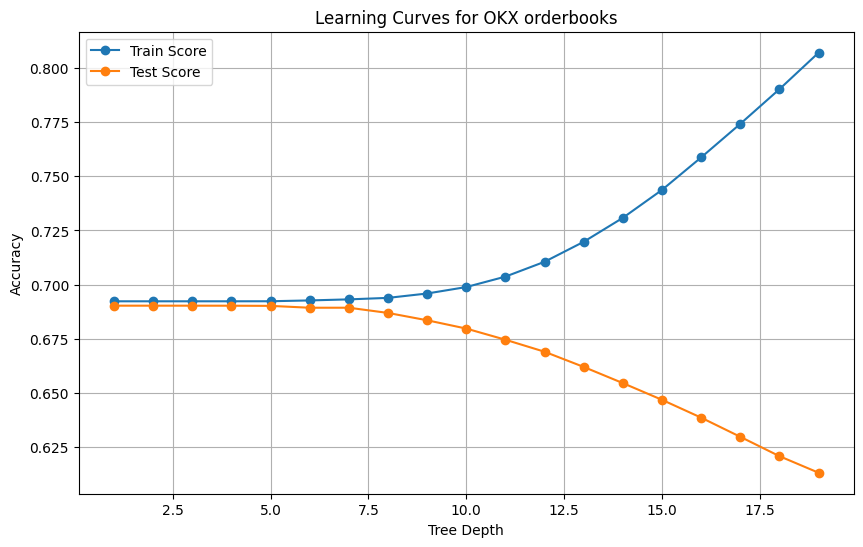

In [6]:
# Initialize the parameter grids and evaluation storage
best_params = {}
best_score = {}
evaluation = {}

# Define parameter ranges for RandomForestClassifier
param_distributions = {
    'n_estimators': [100, 200, 300],
    'max_depth': range(1, 20),
    'min_samples_split': [10, 20, 50, 100],
    'min_samples_leaf': [10, 20, 30, 50]
}

for (data_type, exchange), df in data.items():
    clf = RandomForestClassifier(random_state=42)

    # Initialize the RandomizedSearchCV object
    randomized_search = RandomizedSearchCV(estimator=clf, param_distributions=param_distributions, n_iter=50, cv=CV_FOLDS, scoring='accuracy', n_jobs=-1, random_state=42)

    # Fit the grid search to the data
    randomized_search.fit(df['X_train'], df['y_train'])

    # Best parameters and score
    best_params[(data_type, exchange)] = randomized_search.best_params_
    best_score[(data_type, exchange)] = randomized_search.best_score_
    print(f"Best parameters for {exchange} {data_type}: {best_params[(data_type, exchange)]}")

    # Train the classifier with the best parameters
    clf = RandomForestClassifier(random_state=42, **best_params[(data_type, exchange)])
    clf.fit(df['X_train'], df['y_train'])

    # Predict on the test set
    df['y_pred'] = clf.predict(df['X_test'])

    evaluation[(data_type, exchange)] = {}

    # Calculate accuracy
    evaluation[(data_type, exchange)]['accuracy'] = accuracy_score(df['y_test'], df['y_pred'])

    # Convert classification report to DataFrame
    report = classification_report(df['y_test'], df['y_pred'], target_names=['positive', 'neutral', 'negative'], digits=2, output_dict=True)
    evaluation[(data_type, exchange)]['classification_report'] = pd.DataFrame(report).transpose()

    # Convert confusion matrix to DataFrame
    evaluation[(data_type, exchange)]['confusion_matrix'] = pd.DataFrame(
        confusion_matrix(df['y_test'], df['y_pred']),
        index=['true:positive', 'true:neutral', 'true:negative'],
        columns=['pred:positive', 'pred:neutral', 'pred:negative']
    )
    pd.DataFrame.to_pickle(evaluation, os.path.join(PROCESSED_DATA_PATH, f'{exchange}_{data_type}_evaluation.pkl'))

    # Display results
    print(f'{exchange} {data_type} Accuracy: {evaluation[(data_type, exchange)]["accuracy"]:.2f}')
    print(f'{exchange} {data_type} Classification Report:')
    display(evaluation[(data_type, exchange)]['classification_report'])
    print(f'{exchange} {data_type} Confusion Matrix:')
    display(evaluation[(data_type, exchange)]['confusion_matrix'])    

    # Calculate cross-validated train and test scores for plotting learning curves
    train_scores = []
    test_scores = []
    depths = range(1, 20)

    for depth in depths:
        model = RandomForestClassifier(max_depth=depth, random_state=42, n_estimators=best_params[(data_type, exchange)]['n_estimators'], 
                                       min_samples_split=best_params[(data_type, exchange)]['min_samples_split'], 
                                       min_samples_leaf=best_params[(data_type, exchange)]['min_samples_leaf'])
        model.fit(df['X_train'], df['y_train'])
        train_scores.append(model.score(df['X_train'], df['y_train']))
        test_scores.append(np.mean(cross_val_score(model, df['X_test'], df['y_test'], cv=CV_FOLDS)))

    plot_tree_learning_curves(exchange, data_type, depths, train_scores, test_scores, 'random_forest')

    pd.DataFrame.to_pickle(best_params[(data_type, exchange)], os.path.join(PROCESSED_DATA_PATH, f'best_params.pkl'))
    pd.DataFrame.to_pickle(best_score[(data_type, exchange)], os.path.join(PROCESSED_DATA_PATH, f'best_score.pkl'))


In [ ]:
# from sklearn.model_selection import cross_val_score

# for (data_type, exchange), df in data.items():
#     # Performing 10-fold cross-validation
#     scores = cross_val_score(clf[(data_type, exchange)], X[(data_type, exchange)], y[(data_type, exchange)], cv=10)
#     print("Average cross-validation score: {:.2f}".format(scores.mean()))
